# Resolution Evaluation

This notebook provides the code for the reolution evaluation on a PICMUS real world data-set. Furthermore, there is the contrast evaluation of a circular echoic region.

The notebook is layed out in a way that two beamformers are applied to the same data and evaluated using the same metrics. It is recommended to leave the first beamformer as a DAS beamformer to have a baseline and use the beamformer class one wants to scrutinize as the second one.

In [1]:
"""
   Copyright (C) 2021 ETH Zurich. All rights reserved.

   Author: Wolfgang Boettcher, ETH Zurich

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
"""

import os
from os.path import abspath
from os.path import dirname as up
import numpy as np
import sys

%matplotlib notebook

In [2]:
# path_to_lib = os.path.abspath("__file__")
path_to_lib = up(up(up(up(up(os.path.abspath("__file__"))))))
sys.path.insert(0, path_to_lib)
# os.path.dirname(os.path.abspath("__file__"))
from pybf.pybf.io_interfaces import DataLoader
from pybf.scripts.beamformer_DAS_ref import BFCartesianReference
from pybf.scripts.beamformer_mvbf_spatial_smooth import BFMVBFspatial
from pybf.scripts.beamformer_mvbf_DCR import BFMVBFdcr
from pybf.pybf.image_settings import ImageSettings
from pybf.pybf.visualization import plot_image
from pybf.scripts.picmus_eval import PicmusEval

### Import data

In [3]:
dataset_path_resolution = path_to_lib + '/pybf/tests/data/Picmus/resolution_distorsion/rf_dataset.hdf5'
data_loader_obj_resolution = DataLoader(dataset_path_resolution)

 ### Image settings
  
For some beamformers evaluated in the project, the tx_strategy needs to be set up in a way that at least two plane waves need to be emitted from different angles.

In [4]:
### Specify Image settings and create corresponding object ###

img_res = [400, 600]
image_x_range = [-0.019, 0.019]
image_z_range = [0.005, 0.05]

db_range = 50

LATERAL_PIXEL_DENSITY_DEFAULT = 5

img_config = ImageSettings(image_x_range[0],
                           image_x_range[1],
                           image_z_range[0],
                           image_z_range[1],
                           LATERAL_PIXEL_DENSITY_DEFAULT,
                           data_loader_obj_resolution.transducer)

### Specify preprocessing parameters for RF data ###

decimation_factor = 1
interpolation_factor = 10

### Specify TX strategy and Apodization parameters ###

start_time = 0
correction_time_shift = 0

alpha_fov_apod = 40

# 1 Plane waves with inclination angle 0
# tx_strategy = ['PW_75_16', [16]]
# 4 Plane waves with different but symmetrical inclination angles
tx_strategy = ['PW_4_2.1', [data_loader_obj_resolution.tx_strategy[1][33], data_loader_obj_resolution.tx_strategy[1][37], data_loader_obj_resolution.tx_strategy[1][38], data_loader_obj_resolution.tx_strategy[1][42]]]
rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj_resolution.get_rf_data(0, 0).shape
rf_data = np.zeros(rf_data_shape)
inclin_index = np.asarray([33, 37, 38, 42])
for i in range(rf_data.shape[0]):
    rf_data[i, :, :] = data_loader_obj_resolution.get_rf_data(0, inclin_index[i])

### Specify Sampling Frequency ###

SAMPLING_FREQ = 20.832 * (10 ** 6)

filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]


The highest resolution for the system is:  (633, 205)


 ## Instantiate beamformers

In [5]:
print("  Beamformer 1 \n-------------------------------------")
bf = BFCartesianReference(data_loader_obj_resolution.f_sampling,
                         tx_strategy,
                         data_loader_obj_resolution.transducer,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=filters_params,
                         envelope_detector='I_Q',
                         picmus_dataset=True,
                         channel_reduction=32)                           # Enter number of active receive channels here
print("------------------------------------- \n  Beamformer 2 \n-------------------------------------")
bf2 = BFMVBFdcr(data_loader_obj_resolution.f_sampling,
                         tx_strategy,
                         data_loader_obj_resolution.transducer,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=filters_params,
                         envelope_detector='I_Q',
                         picmus_dataset=True,
                         channel_reduction=32,                           # Enter number of active receive channels here
                         window_width=16)                                # Enter width of sliding window here when using
                                                                         # spatial smoothing

  Beamformer 1 
-------------------------------------
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.1 °
Apodization precalculation...
------------------------------------- 
  Beamformer 2 
-------------------------------------
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.1 °
Apodization precalculation...


 ## Beamform
 
 Performs the beamforming for the whole image
 
 **Note:** This part of the code is by far the most computationally expensive step. Beamforming using a MVBF beamformer can take several minutes (up to approx. 20 minutes) if a high number of channels is used!

In [6]:
print("  Beamformer 1 \n-------------------------------------")
img_data = bf.beamform(rf_data, numba_active=True)
print("------------------------------------- \n  Beamformer 2 \n-------------------------------------")
img_data2 = bf2.beamform(rf_data, numba_active=False)

  Beamformer 1 
-------------------------------------
Beamforming...
 
Time of execution: 13.88241958618164 seconds
------------------------------------- 
  Beamformer 2 
-------------------------------------
Beamforming...
 
Time of execution: 91.89572024345398 seconds


## Evaluations

For both beamformers the Full-Width at Half-Maximum (FWHM) metric is calculated for a number of predefined scatterers in the test data in meters.

### Eval DAS [bf1]

BF Final dB range (-50.0,0.0)


/home/vsergei/Projects/repos/pybf/pybf/visualization.py:54: RuntimeWarning:

divide by zero encountered in log10



<IPython.core.display.Javascript object>


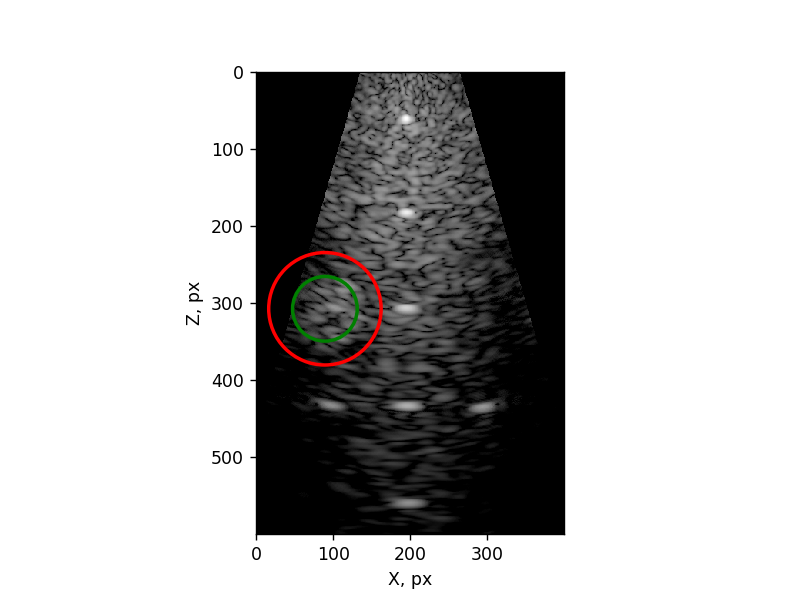

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


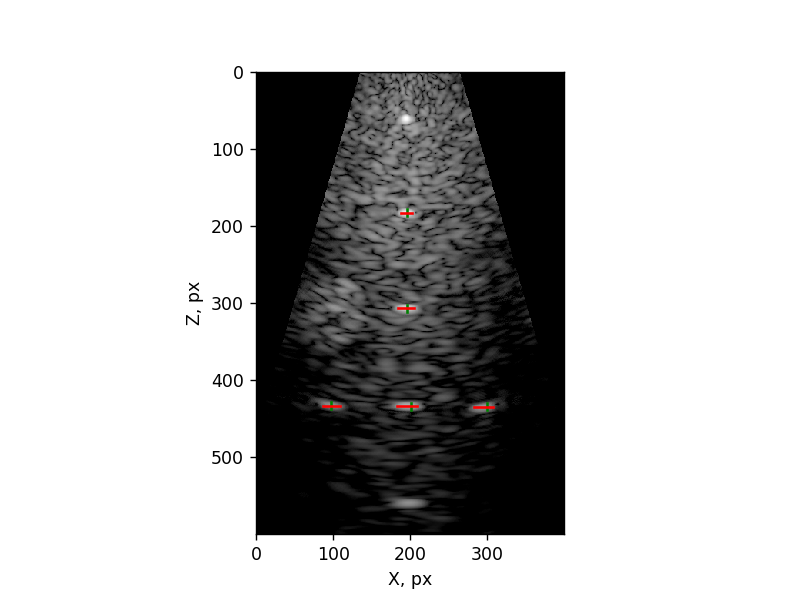

In [7]:
eval_obj = PicmusEval(img_data, bf)
circle_pos = np.asarray([[-0.0105, 0.0281, 0.007, 0.004]])
CNR_values = eval_obj.evaluate_circ_contrast(circle_pos)

scatterer_pos = np.asarray([[-0.001, 0.018, 0.001, 0.001],
                            [-0.001, 0.0277, 0.001, 0.001],
                            [0.0001, 0.0375, 0.001, 0.001],
                           [-0.0104, 0.0375, 0.001, 0.001],
                           [0.0095, 0.0375, 0.001, 0.001]])
FWHM_x, FWHM_y = eval_obj.evaluate_FWHM(scatterer_pos,is_plot=True, plot_name="FWHM_eval")

In [8]:
print("CNR values are [dB]:")
print(str(CNR_values) + "\n")
print("x-axis FWHM values are [m]:")
print(str(FWHM_x))
print("z-axis FWHM values are [m]:")
print(str(FWHM_y))

CNR values are [dB]:
[1.98054038]

x-axis FWHM values are [m]:
[0.00133333 0.002      0.00257143 0.00209524 0.00238095]
z-axis FWHM values are [m]:
[0.000601   0.00067613 0.00067613 0.00067613 0.00075125]


### Eval MVBF [bf2]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


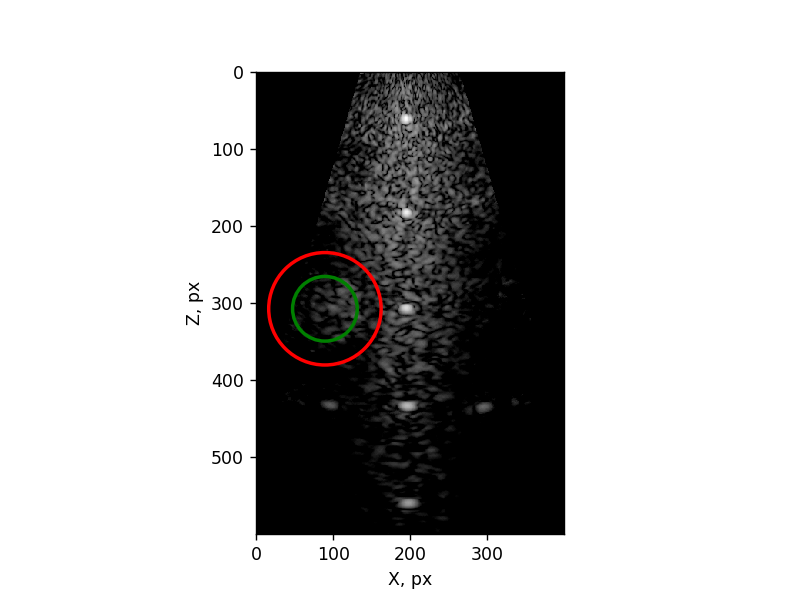

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


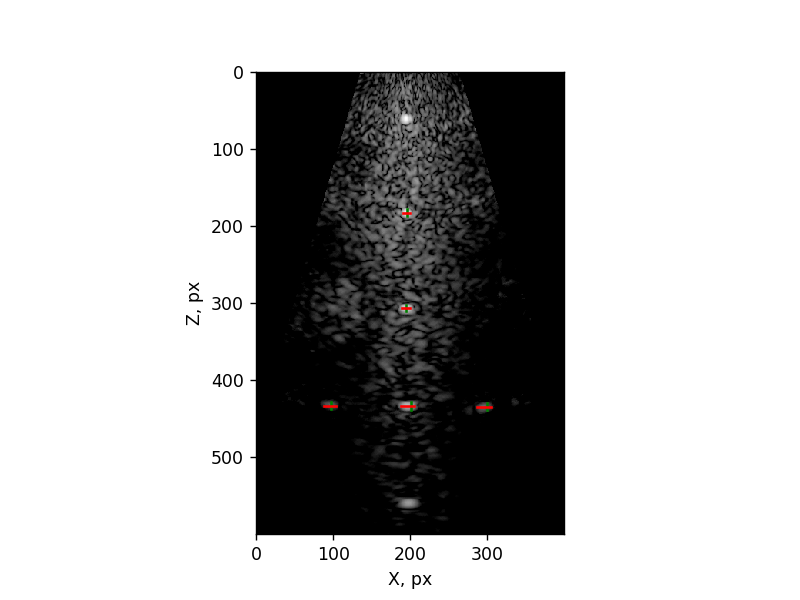

In [9]:
eval_obj2 = PicmusEval(img_data2, bf)
CNR_values2 = eval_obj2.evaluate_circ_contrast(circle_pos)
FWHM_x2, FWHM_y2 = eval_obj2.evaluate_FWHM(scatterer_pos)

In [10]:
print("CNR values are [dB]:")
print(str(CNR_values2) + "\n")
print("x-axis FWHM values are [m]:")
print(str(FWHM_x2))
print("z-axis FWHM values are [m]:")
print(str(FWHM_y2))

CNR values are [dB]:
[0.58574384]

x-axis FWHM values are [m]:
[0.00085714 0.00104762 0.00161905 0.00152381 0.00180952]
z-axis FWHM values are [m]:
[0.000601   0.000601   0.00075125 0.00067613 0.00075125]


 ### Visualize - DAS [bf]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


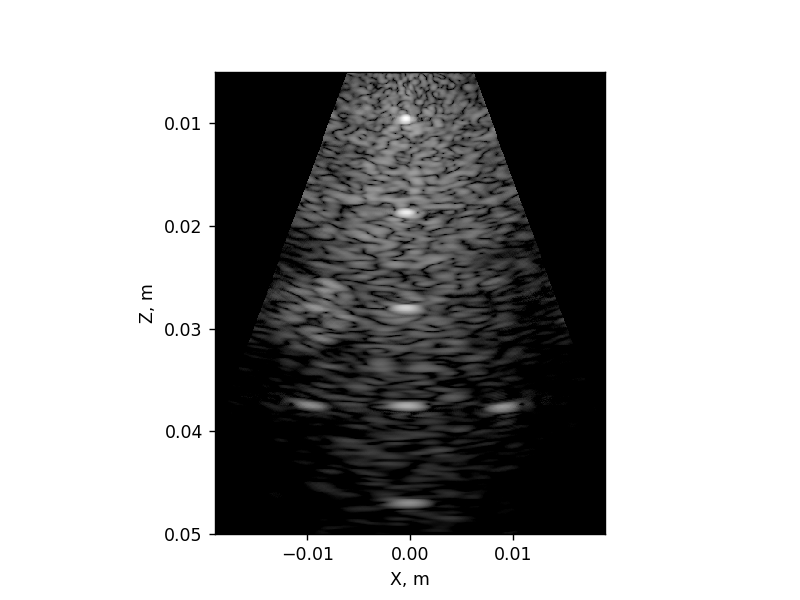

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8ffc28470>)

In [11]:
plot_image(np.abs(img_data), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='DAS',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')


### Visualize - MVBF [bf2]

BF Final dB range (-50.0,0.0)


<IPython.core.display.Javascript object>


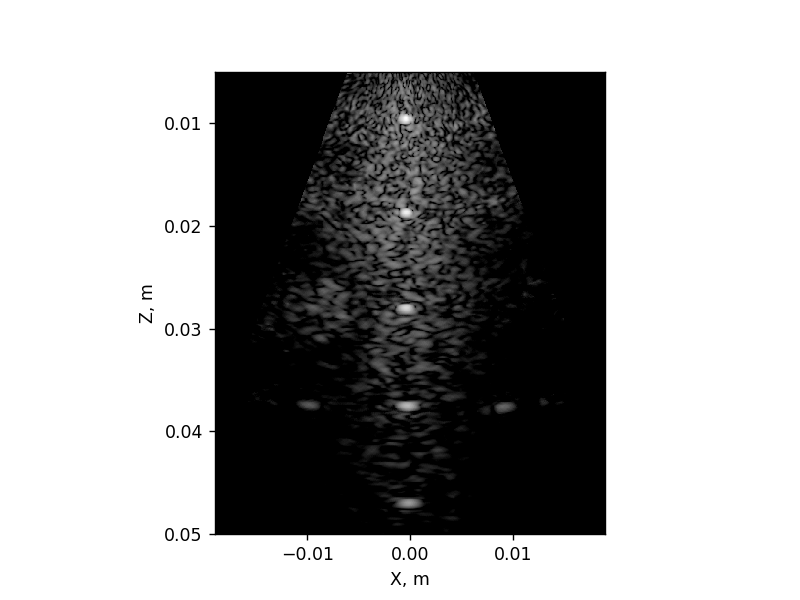

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff8ffc55d68>)

In [12]:
plot_image(np.abs(img_data2), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='MVBFdcr',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')